In [1]:
import pickle
import pkg_resources
import matplotlib.pyplot as plt
import numpy as np
import imageio
from pathlib import Path

from flygym.arena.mujoco_arena import (
    FlatTerrain,
    GappedTerrain,
    BlocksTerrain,
    MixedTerrain,
)
from flygym.envs.nmf_mujoco import NeuroMechFlyMuJoCo, MuJoCoParameters
from flygym.state import stretched_pose
from flygym.util.config import all_leg_dofs

In [2]:
arenas = {
    "flat": FlatTerrain(),
    "gapped": GappedTerrain(),
    "blocks": BlocksTerrain(),
    "mixed": MixedTerrain(),
}

Load recorded kinematics data

In [3]:
run_time = 1
timestep = 1e-4
actuated_joints = all_leg_dofs

# Load recorded data
data_path = Path(pkg_resources.resource_filename("flygym", "data"))
with open(data_path / "behavior" / "210902_pr_fly1.pkl", "rb") as f:
    data = pickle.load(f)

# Interpolate 5x
num_steps = int(run_time / timestep)
data_block = np.zeros((len(actuated_joints), num_steps))
measure_t = np.arange(len(data["joint_LFCoxa"])) * data["meta"]["timestep"]
interp_t = np.arange(num_steps) * timestep
for i, joint in enumerate(actuated_joints):
    data_block[i, :] = np.interp(interp_t, measure_t, data[joint])

In [4]:
images = {}
for name, arena in arenas.items():
    print(f"Working on {name}")
    sim_params = MuJoCoParameters(timestep=1e-4, render_mode="saved", render_playspeed=0.1)
    nmf = NeuroMechFlyMuJoCo(
        sim_params=sim_params,
        init_pose=stretched_pose,
        actuated_joints=all_leg_dofs,
        arena=arena,
        spawn_pos=(2, 0, 0.1) if name == "mixed" else (0, 0, 0.1),
    )
    obs_list = []
    for i in range(500):
        joint_pos = data_block[:, i]
        action = {"joints": joint_pos}
        obs, reward, terminated, truncated, info = nmf.step(action)
        nmf.render()
        obs_list.append(obs)
    nmf.close()
    img = nmf.physics.render(720, 720, camera_id="Animat/camera_left")
    images[name] = img

Working on flat
Working on gapped
Working on blocks
Working on mixed


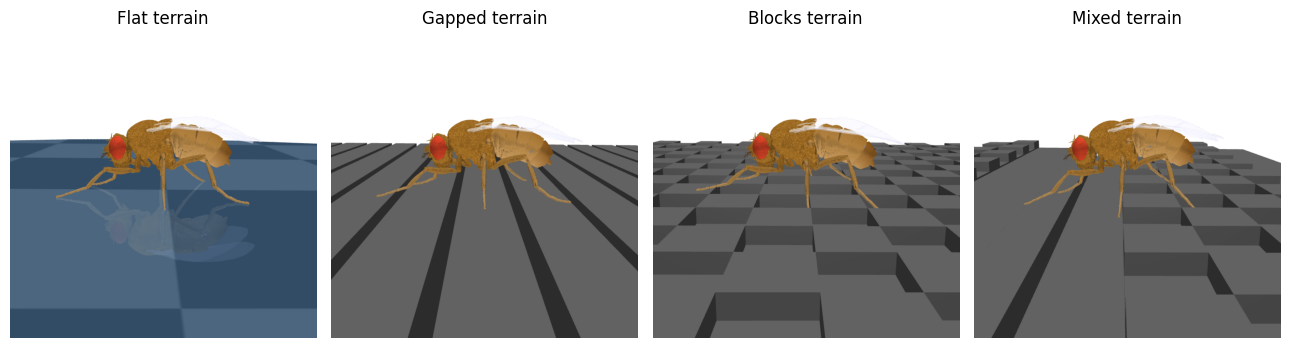

In [5]:
fig, axs = plt.subplots(1, 4, figsize=(13, 4))
for i, (name, img) in enumerate(images.items()):
    axs[i].imshow(img)
    axs[i].set_title(f"{name.title()} terrain")
    axs[i].axis("off")
    imageio.imsave(f"outputs/{name}.png", img)
plt.tight_layout()
plt.savefig("outputs/all.png")